In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/ratings_Electronics.csv')

In [ ]:
df.columns = ['reviewerID', 'product_id', 'rating', 'date']
df.head()

,reviewerID,product_id,rating,date
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
df['date'] = pd.to_datetime(df['date'], unit='s')
df.sort_values(by=['reviewerID', 'date'], inplace=True)

In [ ]:
product_ids = df['product_id'].unique()
product_id_map = {product_id: i + 1 for i, product_id in enumerate(product_ids)}

In [ ]:
unique_products = df['product_id'].unique()
product_to_idx = {product: idx for idx, product in enumerate(unique_products)}
num_products = len(unique_products)
df['product_idx'] = df['product_id'].map(product_to_idx)

In [ ]:
# Split the data into train and test sets based on 'reviewerID' to avoid overlap
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['reviewerID']))
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]

In [ ]:
from tqdm import tqdm
import numpy as np

def create_interaction_array_with_dislike_flag(df1, k, dislike_threshold=3):
    """
    Creates a NumPy array of the first 3 product interactions for each user, a yratings array,
    and a dislike flag array.

    Args:
        df: DataFrame with 'reviewerID', 'product_idx', and 'rating' columns.
        k: Total number of products (length of the yratings array).
        dislike_threshold: Rating threshold to mark a product as disliked (default is 3).

    Returns:
        - interaction_matrix: NumPy array of shape (num_users, 3, 2), where each inner array represents
          a user's first 3 interactions as [[product_id, rating], ...]. Returns None if a user has fewer than 3 interactions.
        - yratings: NumPy array of shape (num_users, k), where each array represents ratings for k products,
          with zeros where the user has no interaction.
        - dislike_flags: NumPy array of shape (num_users, 3), where each entry is 1 if the corresponding product's
          rating is less than or equal to the dislike_threshold, 0 otherwise.
    """
    df = df1.copy()

    df['product_idx'] = df['product_idx'].astype(np.int16)
    df['rating'] = df['rating'].astype(np.int8)

    interaction_arrays = []
    yratings_list = []
    dislike_flags_list = []

    for user_id, user_df in tqdm(df.groupby('reviewerID'), desc="Processing users"):
        if len(user_df) >= 3:
            interactions = user_df[['product_idx', 'rating']].values[:3].astype(np.int16)

            yratings = np.zeros(k, dtype=np.int8)

            # Populate yratings with user's ratings at the corresponding product indices
            for idx, rating in zip(user_df['product_idx'], user_df['rating']):
                yratings[idx] = rating

            dislike_flags = np.zeros(3, dtype=np.int8)
            for i in range(1, 3):
                if user_df['rating'].iloc[i-1] <= dislike_threshold:
                    dislike_flags[i-1] = 1

            interaction_arrays.append(interactions)
            yratings_list.append(yratings)
            dislike_flags_list.append(dislike_flags)

    return (
        np.array(interaction_arrays, dtype=np.int16),
        np.array(yratings_list, dtype=np.int8),
        np.array(dislike_flags_list, dtype=np.int8),
    )


In [ ]:
k = len(product_ids)
interaction_matrix, yratings_array, dislike_flags_array = create_interaction_array_with_dislike_flag(train_df, k)

Processing users: 100%|██████████| 1964334/1964334 [03:58<00:00, 8245.40it/s]


In [ ]:
product_ids = interaction_matrix[:, :, 0]
ratings = interaction_matrix[:, :, 1]
dislike_flags = dislike_flags_array

In [ ]:
def masked_mse(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    mse = tf.square(tf.cast(y_true, tf.float32) - y_pred) * mask
    return tf.reduce_sum(mse) / tf.reduce_sum(mask)

def masked_mae(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    mae = tf.abs(tf.cast(y_true, tf.float32) - y_pred) * mask
    return tf.reduce_sum(mae) / tf.reduce_sum(mask)

def masked_rmse(y_true, y_pred):
    mse = masked_mse(y_true, y_pred)
    return tf.sqrt(mse)

In [ ]:
import matplotlib.pyplot as plt

def plot_model_history(history):
    """
    Plots the training and validation metrics (loss, MAE, and RMSE) from a model's history object.

    Parameters:
    - history: The history object from model.fit() containing training and validation metrics.

    Returns:
    - None. Displays the plots.
    """
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.show()

    # Plot training & validation MAE values
    plt.figure(figsize=(10, 5))
    if 'masked_mae' in history.history and 'val_masked_mae' in history.history:
        plt.plot(history.history['masked_mae'], label='Train')
        plt.plot(history.history['val_masked_mae'], label='Validation')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("MAE metrics not found in the history.")

    # Plot training & validation RMSE values
    plt.figure(figsize=(10, 5))
    if 'masked_rmse' in history.history and 'val_masked_rmse' in history.history:
        plt.plot(history.history['masked_rmse'], label='Train')
        plt.plot(history.history['val_masked_rmse'], label='Validation')
        plt.title('Model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()
    else:
        print("RMSE metrics not found in the history.")


In [ ]:
k = len(product_ids)
interaction_matrix_test, yratings_array_test, dislike_flags_array_test = create_interaction_array_with_dislike_flag(test_df, k)

Processing users: 100%|██████████| 491084/491084 [00:52<00:00, 9320.80it/s]


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def test_model(model, interaction_matrix_test, yratings_array_test, dislike_flags_array_test):
    """
    Evaluates the model performance on the test set using RMSE and MAE, masking out zero values in true ratings.

    Parameters:
    - model: The trained Keras model.
    - interaction_matrix_test: Test set interaction matrix (shape: (num_samples, sequence_length, 2)).
    - yratings_array_test: True ratings for the test set (shape: (num_samples, num_products)).
    - dislike_flags_array_test: Dislike flags for the test set (shape: (num_samples, sequence_length)).

    """
    product_ids_test = interaction_matrix_test[:, :, 0]
    ratings_test = interaction_matrix_test[:, :, 1]
    dislike_flags_test = dislike_flags_array_test

    y_pred = model.predict([product_ids_test, ratings_test, dislike_flags_test])

    mask = yratings_array_test != 0
    y_true_masked = yratings_array_test[mask]
    y_pred_masked = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true_masked, y_pred_masked))

    mae = mean_absolute_error(y_true_masked, y_pred_masked)

    print(f"Test RMSE (masked): {rmse}")
    print(f"Test MAE (masked): {mae}")


# GRU

In [ ]:
#GRU Arch

product_input = layers.Input(shape=(3,), name="product_input", dtype=tf.int32)
rating_input = layers.Input(shape=(3,), name="rating_input", dtype=tf.float32)
dislike_flag_input = layers.Input(shape=(3,), name="dislike_flag_input", dtype=tf.float32)

# Embedding layers
product_embedding = layers.Embedding(input_dim=len(product_ids), output_dim=50)(product_input)
rating_embedding = layers.Embedding(input_dim=6, output_dim=1)(rating_input)
dislike_flag_input_expanded = layers.Reshape((3, 1))(dislike_flag_input)

# Combine embeddings and flags
merged_input = layers.Concatenate(axis=-1)([product_embedding, rating_embedding, dislike_flag_input_expanded])

merged_input = layers.BatchNormalization()(merged_input)
merged_input = layers.Dropout(0.6)(merged_input)

rnn_output = layers.Bidirectional(layers.GRU(64, return_sequences=False))(merged_input)
rnn_output = layers.BatchNormalization()(rnn_output)
rnn_output = layers.Dropout(0.6)(rnn_output)

dense_output = layers.Dense(k, activation='linear')(rnn_output)

modelgru = models.Model(inputs=[product_input, rating_input, dislike_flag_input], outputs=dense_output)

modelgru.compile(optimizer='adam', loss=masked_mse, metrics=[masked_mae,masked_rmse])

modelgru.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ product_input             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_input (InputLayer) │ (None, 3)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dislike_flag_input        │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 3, 50)          │     10,150,250 │ product_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 3, 1)           │              6 │ rating_input[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 3, 1)           │              0 │ dislike_flag_input[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 3, 52)          │              0 │ embedding_4[0][0],     │
│ (Concatenate)             │                        │                │ embedding_5[0][0],     │
│                           │                        │                │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 3, 52)          │            208 │ concatenate_2[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 3, 52)          │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 128)            │         45,312 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128)            │            512 │ bidirectional_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 7474)           │        964,146 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,160,434 (42.57 MB)

 Trainable params: 11,160,074 (42.57 MB)

 Non-trainable params: 360 (1.41 KB)

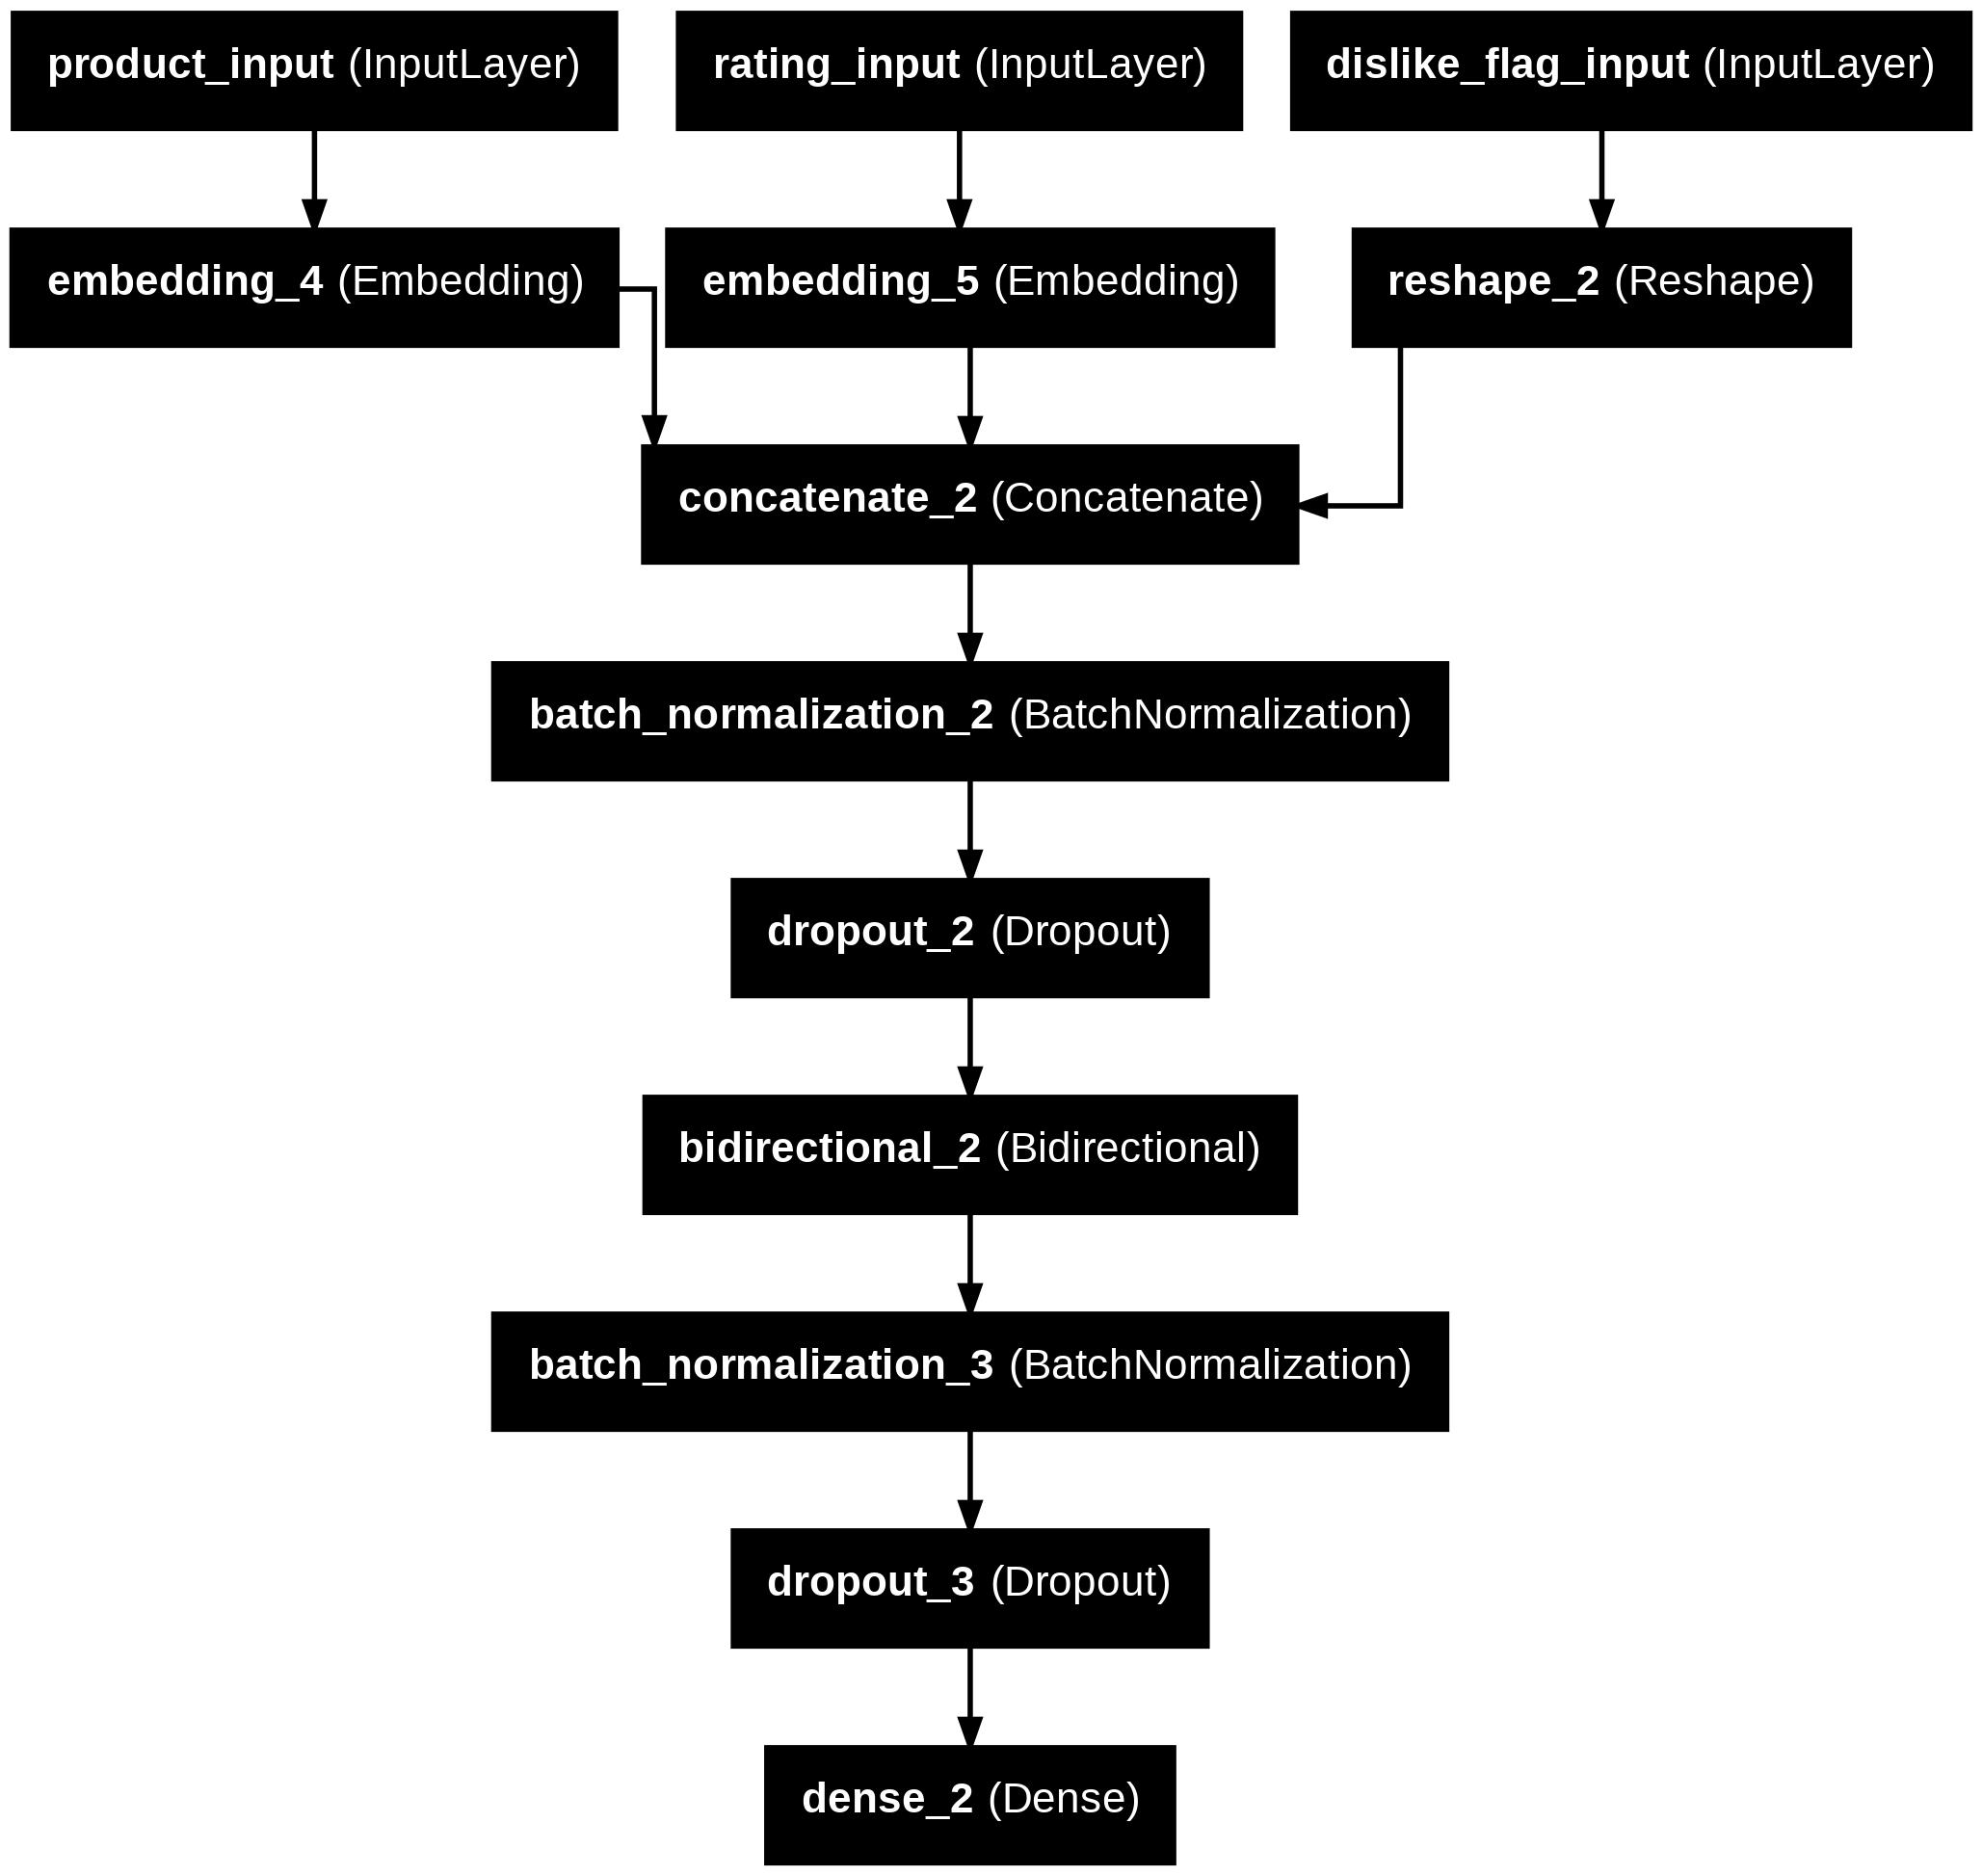

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(modelgru, to_file='plot.png', show_layer_names=True)

In [ ]:
history_gru = modelgru.fit(
    [product_ids, ratings, dislike_flags],
    yratings_array,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 9.3984 - masked_mae: 2.5373 - masked_rmse: 2.8168 - val_loss: 1.1239 - val_masked_mae: 0.8034 - val_masked_rmse: 1.0562
Epoch 2/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - loss: 1.6427 - masked_mae: 1.0031 - masked_rmse: 1.2774 - val_loss: 1.0786 - val_masked_mae: 0.7956 - val_masked_rmse: 1.0344
Epoch 3/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.4798 - masked_mae: 0.9441 - masked_rmse: 1.2124 - val_loss: 1.0288 - val_masked_mae: 0.7676 - val_masked_rmse: 1.0098
Epoch 4/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 83s 15ms/step - loss: 1.3996 - masked_mae: 0.9141 - masked_rmse: 1.1789 - val_loss: 0.9912 - val_masked_mae: 0.7421 - val_masked_rmse: 0.9910
Epoch 5/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 81s 15ms/step - loss: 1.3415 - masked_mae: 0.8908 - masked_rmse: 1.1540 - val_loss: 0.9465 - val_masked_mae: 0.7181 - val_masked_rmse: 0.9681
Epoch 6/50
5076/5076 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 1.3094 - masked_

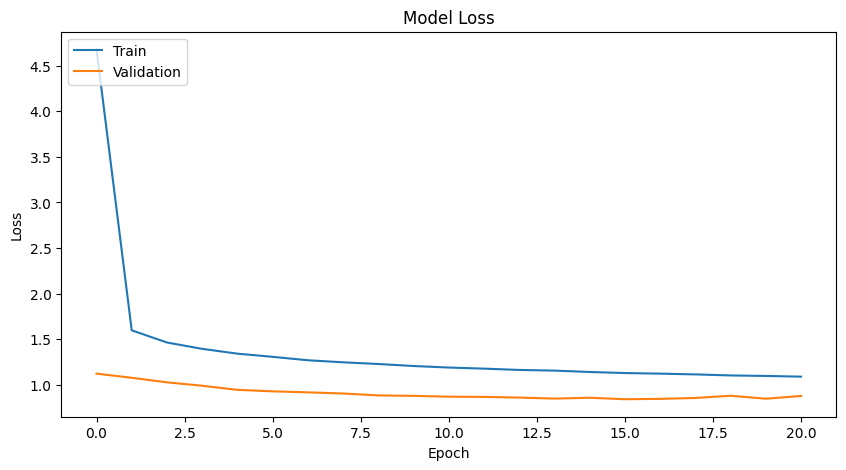

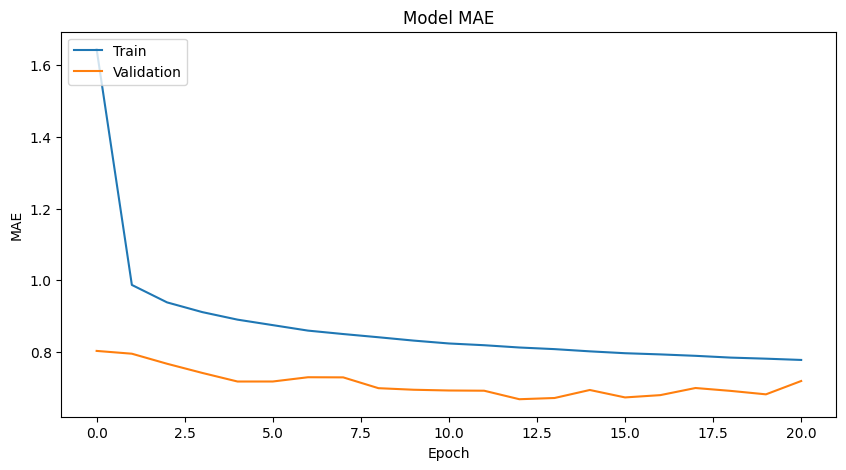

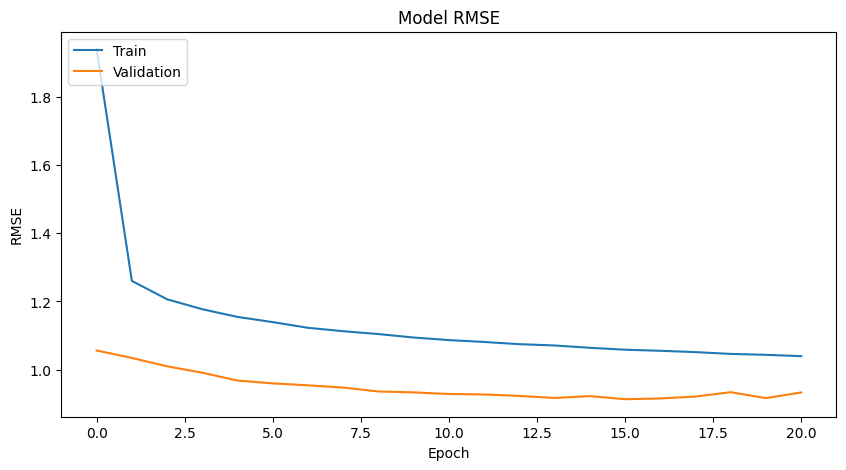

In [ ]:
plot_model_history(history_gru)

In [ ]:
test_model(modelgru, interaction_matrix_test, yratings_array_test, dislike_flags_array_test)

1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step
Test RMSE (masked): 0.9168267250061035
Test MAE (masked): 0.6735901236534119


In [ ]:
modelgru.save('/content/drive/MyDrive/Model/modelgru.keras')

# Ensemble

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_lstm1 = load_model('/content/drive/MyDrive/Model/model_lstm1.keras', custom_objects={'masked_mse': masked_mse, 'masked_mae': masked_mae, 'masked_rmse': masked_rmse})
model_lstm2 = load_model('/content/drive/MyDrive/Model/model_lstm2.keras', custom_objects={'masked_mse': masked_mse, 'masked_mae': masked_mae, 'masked_rmse': masked_rmse})
model_gru = load_model('/content/drive/MyDrive/Model/modelgru.keras', custom_objects={'masked_mse': masked_mse, 'masked_mae': masked_mae, 'masked_rmse': masked_rmse})
modelrnn = load_model('/content/drive/MyDrive/Model/modelrnn.keras', custom_objects={'masked_mse': masked_mse, 'masked_mae': masked_mae, 'masked_rmse': masked_rmse})


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import load_model

def test_ensemble_sequential(model_paths, interaction_matrix_test, yratings_array_test, dislike_flags_array_test):
    """
    Evaluates the performance of an ensemble of models (loaded sequentially) on the test set using RMSE and MAE,
    masking out zero values.

    Parameters:
    - model_paths: List of file paths to the trained Keras models.
    - interaction_matrix_test: Test set interaction matrix (shape: (num_samples, sequence_length, 2)).
    - yratings_array_test: True ratings for the test set (shape: (num_samples, num_products)).
    - dislike_flags_array_test: Dislike flags for the test set (shape: (num_samples, sequence_length)).
    """
    product_ids_test = interaction_matrix_test[:, :, 0]
    ratings_test = interaction_matrix_test[:, :, 1]
    dislike_flags_test = dislike_flags_array_test

    # Initialize a placeholder for cumulative predictions
    cumulative_predictions = np.zeros_like(yratings_array_test, dtype=np.float32)
    num_models = len(model_paths)

    for model_path in model_paths:
        # Load model
        model = load_model(model_path, custom_objects={
            'masked_mse': masked_mse, 'masked_mae': masked_mae, 'masked_rmse': masked_rmse
        })

        # Predict with the current model
        y_pred = model.predict([product_ids_test, ratings_test, dislike_flags_test])

        # Accumulate predictions
        cumulative_predictions += y_pred

        # Clear model from memory
        del model
        import gc
        gc.collect()

    # Average predictions
    y_pred_ensemble = cumulative_predictions / num_models

    # Mask zero values in the true ratings
    mask = yratings_array_test != 0
    y_true_masked = yratings_array_test[mask]
    y_pred_masked = y_pred_ensemble[mask]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_true_masked, y_pred_masked))
    mae = mean_absolute_error(y_true_masked, y_pred_masked)

    print(f"Test RMSE (masked, ensemble): {rmse}")
    print(f"Test MAE (masked, ensemble): {mae}")

# Example usage
model_paths = [
    '/content/drive/MyDrive/Model/model_lstm1.keras',
    '/content/drive/MyDrive/Model/model_lstm2.keras',
    '/content/drive/MyDrive/Model/modelgru.keras',
    '/content/drive/MyDrive/Model/modelrnn.keras'
]

test_ensemble_sequential(
    model_paths=model_paths,
    interaction_matrix_test=interaction_matrix_test,
    yratings_array_test=yratings_array_test,
    dislike_flags_array_test=dislike_flags_array_test
)


1582/1582 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1582/1582 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
Test RMSE (masked, ensemble): 0.8362468481063843
Test MAE (masked, ensemble): 0.5867078900337219
